In [13]:
!pip install deeptime

  Using cached deeptime-0.2.9.tar.gz (537 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Command errored out with exit status 1:
   command: /root/venv/bin/python /root/venv/lib/python3.7/site-packages/pip/_vendor/pep517/in_process/_in_process.py build_wheel /tmp/tmpumw_xvbg
       cwd: /tmp/pip-install-6_c23c8i/deeptime_ae3b3d1e4c6a46eb8c5fc0cdd2978b0a
  Complete output (961 lines):
  Appending deeptime.clustering configuration to deeptime
  Ignoring attempt to set 'name' (from 'deeptime' to 'deeptime.clustering')
  Appending deeptime.covariance.util configuration to deeptime.covariance
  Ignoring attempt to set 'name' (from 'deeptime.covariance' to 'deeptime.covariance.util')
  non-existing path in 'deeptime/covariance/util/covar_c': 'include'
  Appending deeptime.covariance.util.covar_c configuration to deeptime.covariance
  Ignoring attempt to set 'name' (from 'deeptime.covariance' to 'deept

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md
import itertools
from stateinterpreter.MD import Loader

import pyemma
import pyemma.coordinates as pyemmacoord

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

## BPTI

Notes: Narjes system, long unbiased MD simulation

### Load trajectory

In [ ]:
# use external integration for large dataset (see https://docs.deepnote.com/integrations/deepnote-shared-datasets)
folder = "/datasets/bpti-unbiased-dataset/"
stride = 10


# load trajectory
traj_file = folder + "all_trj_10ns"
topo_file = folder + "bpti-protein.pdb"

traj = md.load(traj_file, top=topo_file,stride=stride)

# load reference structure (used for Root-mean-square deviation [RMSD] analysis)
ref_file = folder + "chignolin-ref-ca-DES.pdb"
ref = md.load(ref_file)

# general setup 
kb = 0.00831441 #boltzmann constant in [kJ/mol]
temp = 300
kbt = kb * temp


In [ ]:
# PRINT TOPOLOGY with atom properties (serial, name, element,residue_id,residue_name etc)
table, bonds = ref.top.to_dataframe()
table
#table.loc[table['resName'].str.contains("ASP") ]

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,N,N,1,TYR,0,
1,2,H,H,1,TYR,0,
2,3,H2,H,1,TYR,0,
3,4,H3,H,1,TYR,0,
4,5,CA,C,1,TYR,0,
...,...,...,...,...,...,...,...
161,162,HH,H,10,TYR,0,
162,163,CD2,C,10,TYR,0,
163,164,HD2,H,10,TYR,0,
164,165,CE2,C,10,TYR,0,


### Load COLVAR (aka COLlective VARiables)

In [ ]:
filename=folder + 'COLVAR' 

tica1_label = 'deep.node-4'
tica2_label = 'deep.node-3'
tica3_label = 'deep.node-2'

headers = pd.read_csv(filename,sep=' ',skipinitialspace=True, nrows=0).columns[2:]
colvar = pd.read_csv(filename,sep=' ',skipinitialspace=True, header=None,skiprows=1,names=headers,comment='#')  

colvar = colvar.iloc[::stride, :]
colvar.index = np.arange(len(colvar))

#colvar = colvar [ colvar[tica1_label]>0.65 ]

colvar

,time,rmsd_ca,end,hbonds,deep.node-0,deep.node-1,deep.node-2,deep.node-3,deep.node-4
0,0.0,0.067477,0.500523,3.515683,0.156591,0.269741,-0.503362,-0.769360,0.860714
1,10.0,0.040256,0.516848,3.607478,-0.163258,0.031106,0.738618,-0.639663,0.860408
2,20.0,0.062648,0.460648,3.625588,-0.114638,0.244315,0.888992,-0.485358,0.901081
3,30.0,0.067292,0.490304,3.519522,-0.082365,-0.005303,-0.405775,-0.523814,0.901542
4,40.0,0.065588,0.487023,3.634205,0.348991,-0.240763,-0.353688,-0.586350,0.871337
...,...,...,...,...,...,...,...,...,...
52470,524700.0,0.651776,1.920228,0.413543,0.028602,0.230118,0.027031,-0.283929,-0.689612
52471,524710.0,0.543898,1.960420,0.512699,-0.170959,0.161725,-0.014535,-0.523711,-0.522852
52472,524720.0,0.428343,1.464966,0.604115,-0.156648,0.097244,0.012294,-0.381107,-0.555181
52473,524730.0,0.452596,1.448579,0.586075,-0.098890,0.154325,0.106024,-0.387451,-0.569581


In [ ]:
# Calculate FES 

import scipy.stats as st

def compute_fes(colvar,xname,yname,xlim=(-1,1),ylim=(-1,1),nbins=100,max_fes=30):
    global xdata,ydata,xgrid,ygrid,xx,yy

    xdata = colvar[xname].values
    ydata = colvar[yname].values
    xmin, xmax = xlim
    ymin, ymax = ylim

    xgrid = np.linspace(xmin,xmax,nbins)
    ygrid = np.linspace(ymin,ymax,nbins)

    # kernel density estimation for the probability distribution
    #xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] #why 100j? number of points along each direction
    xx,yy = np.meshgrid(xgrid,ygrid)
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    # free energy
    f = - kbt * np.log(f)
    f-= np.min(f)

    #if fes > max_fes set to nan
    f[f>max_fes] = np.NaN

    return f

f = compute_fes(colvar,tica1_label,tica2_label,xlim=(-1.1,1.1),ylim=(-1.1,1.1),nbins=110,max_fes=30)

In [ ]:
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

# https://stackoverflow.com/questions/3986345/how-to-find-the-local-minima-of-a-smooth-multidimensional-array-in-numpy-efficie

def detect_local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value in their neighborhood are set to 1 http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask. we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to successfully subtract it from local_min, otherwise a line will appear along the background border (artifact of the local minimum filter) http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)

20 99 0.8981651376146789 -0.6963302752293579 0.0
38 29 -0.5146788990825688 -0.33302752293577986 3.7310571452291184
55 96 0.8376146788990826 0.010091743119265972 3.67623438582219
88 93 0.7770642201834863 0.6761467889908257 3.516808699194865


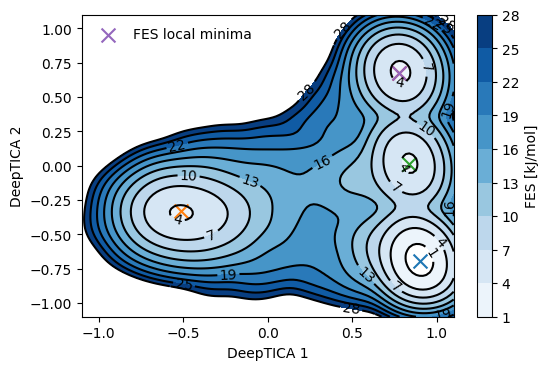

In [ ]:
fig,ax = plt.subplots(dpi=100)

levels = np.arange(1,30,3)

cfset = ax.contourf(xx, yy, f, levels=levels, cmap='Blues')
#cfset = ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, levels=levels, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)

cbar = plt.colorbar(cfset)
ax.set_xlabel('DeepTICA 1')
ax.set_ylabel('DeepTICA 2')
cbar.set_label('FES [kJ/mol]')

local_minima_locations = detect_local_minima(f)
for i,j in zip(*local_minima_locations):
    print(i,j,xx[i,j],yy[i,j],f[i,j])
    ax.scatter(xx[i,j],yy[i,j],marker='x',s=100)
ax.scatter(xx[i,j],yy[i,j],marker='x',s=100,label='FES local minima')
ax.legend(frameon=False,loc=2)

### Clustering -&gt; Labels

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


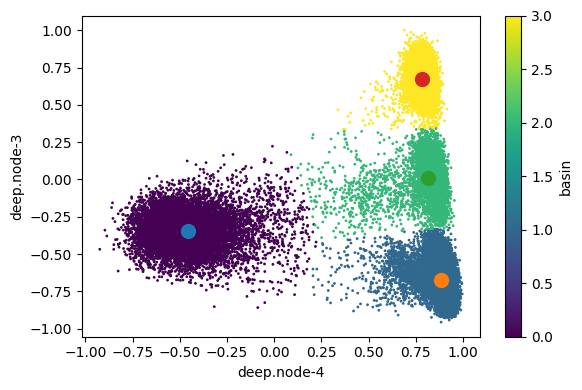

In [ ]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots(dpi=100)

#colvar['weights'] = np.exp( ( colvar['bias'].values - np.max(colvar['bias'].values))/kbt )

tica1 = colvar[tica1_label].values
tica2 = colvar[tica2_label].values
#weights = colvar['weights'].values

X = np.stack([tica1,tica2],axis=1)

n_clusters = 4

#assign initial coordinates to keep labels constant
init_cluster=np.asarray([[-.35,-0.35],[0.9,-.65],[0.9,0.],[.9,.65]])
kmeans = KMeans(n_clusters=n_clusters, init=init_cluster).fit(X)#,sample_weight=weights)
#kmeans = KMeans(n_clusters=n_clusters).fit(X)#,sample_weight=weights)
colvar['basin'] = kmeans.labels_

colvar.plot(x=tica1_label,y=tica2_label,c='basin',kind='scatter',cmap='viridis',ax=ax,s=1)

for center in kmeans.cluster_centers_:
    ax.scatter(center[0],center[1],s=100)

plt.tight_layout()

<AxesSubplot:xlabel='deep.node-4', ylabel='deep.node-3'>

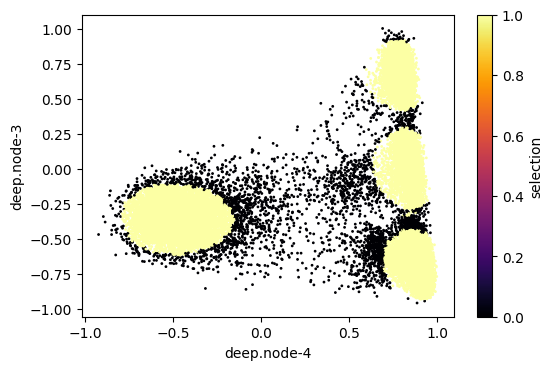

In [ ]:
fes_cutoff = 5 # units kJ/mol

ref_fes = []

#compute fes values for cluster centers
for i in range(n_clusters):
    mx,my = kmeans.cluster_centers_[i]
    idx = (np.abs(xgrid - mx)).argmin()
    idy = (np.abs(ygrid - my)).argmin()
    ref_fes.append( f[idy,idx] )
ref_fes = np.asarray(ref_fes)

#compute fes values for each point
idxs = np.searchsorted(xgrid, xdata, side='left')
idys = np.searchsorted(ygrid, ydata, side='left')

fes = f[idys.tolist(),idxs.tolist()]
colvar['fes'] = fes
colvar['deltaFes'] = fes - ref_fes[colvar['basin']]

#select points whose fes w.r.t. local minimum is lesser than cutoff
colvar['selection'] = (colvar['deltaFes']<fes_cutoff).values.astype(int)

fig, ax = plt.subplots(dpi=100)
colvar.plot.scatter(tica1_label,tica2_label,c='selection',s=1,cmap='inferno',ax=ax)

### Compute descriptors from traj

In [ ]:
# COMPUTE DISTANCES
 
# https://www.mdtraj.org/1.9.5/atom_selection.html

#(a) heavy atom distances
#basename = 'dd_'
#sel = traj.top.select('not type H')
#which is equivalent to:
#sel = [atom.index for atom in traj.top.atoms if atom.element.symbol is not 'H']

#(b) or only CA distances
#basename = 'ca_'
sel = traj.top.select('name CA')

pairs = [ (i,j) for i,j in itertools.combinations(sel,2) ]
dist = md.compute_distances(traj,pairs)

#compute labels
label = lambda i,j : 'DIST. %s%s -- %s%s' % (traj.top.atom(i), 's' if traj.top.atom(i).is_sidechain else '',
                                      traj.top.atom(j), 's' if traj.top.atom(j).is_sidechain else '')

#names = [basename+str(i)+'-'+str(j) for (i,j) in pairs]
names = [label(i,j) for (i,j) in pairs]

df = pd.DataFrame(data=dist,columns=names)
colvar = colvar.join(df)
print(df.shape)

(52475, 45)


In [ ]:
df

,DIST. TYR1-CA -- TYR2-CA,DIST. TYR1-CA -- ASP3-CA,DIST. TYR1-CA -- PRO4-CA,DIST. TYR1-CA -- GLU5-CA,DIST. TYR1-CA -- THR6-CA,DIST. TYR1-CA -- GLY7-CA,DIST. TYR1-CA -- THR8-CA,DIST. TYR1-CA -- TRP9-CA,DIST. TYR1-CA -- TYR10-CA,DIST. TYR2-CA -- ASP3-CA,...,DIST. THR6-CA -- GLY7-CA,DIST. THR6-CA -- THR8-CA,DIST. THR6-CA -- TRP9-CA,DIST. THR6-CA -- TYR10-CA,DIST. GLY7-CA -- THR8-CA,DIST. GLY7-CA -- TRP9-CA,DIST. GLY7-CA -- TYR10-CA,DIST. THR8-CA -- TRP9-CA,DIST. THR8-CA -- TYR10-CA,DIST. TRP9-CA -- TYR10-CA
0,0.382577,0.730466,0.997654,1.275664,1.293217,1.079655,0.913451,0.640626,0.500523,0.378884,...,0.369246,0.546729,0.903599,1.139596,0.379419,0.660002,0.970056,0.377391,0.654879,0.375005
1,0.387222,0.646558,0.936337,1.180649,1.193879,1.068397,0.842418,0.587498,0.516848,0.375782,...,0.394596,0.554482,0.910634,1.141241,0.376628,0.676561,1.000217,0.384626,0.650765,0.375683
2,0.381795,0.724815,1.029717,1.275074,1.222712,1.040496,0.836780,0.549003,0.460648,0.388150,...,0.376971,0.524973,0.884991,1.074497,0.380717,0.663750,0.956773,0.379843,0.620648,0.374880
3,0.372318,0.649956,0.967070,1.186393,1.172688,1.046110,0.857409,0.569407,0.490304,0.374159,...,0.374269,0.536100,0.859717,0.999108,0.398532,0.654980,0.927860,0.375766,0.588168,0.390490
4,0.388854,0.688958,0.998880,1.260611,1.218665,1.068493,0.835109,0.548831,0.487023,0.370185,...,0.381203,0.531074,0.901934,1.079672,0.373491,0.702548,0.992429,0.388512,0.642709,0.377425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52470,0.382249,0.582712,0.658730,0.922278,1.257723,1.439145,1.825918,1.886149,1.920228,0.384690,...,0.376848,0.695673,0.849604,0.826053,0.388252,0.569635,0.709199,0.378832,0.595462,0.384878
52471,0.388739,0.558530,0.798860,1.043313,1.316431,1.527002,1.484909,1.615480,1.960420,0.385304,...,0.378030,0.592986,0.870756,0.986903,0.391712,0.563638,0.622337,0.384883,0.557134,0.386974
52472,0.374689,0.568989,0.782038,0.974678,1.254486,1.368538,1.285660,1.185312,1.464966,0.385065,...,0.382014,0.570762,0.829289,0.901449,0.395061,0.583206,0.542682,0.379806,0.567705,0.386780
52473,0.390620,0.518794,0.734631,0.680824,1.044974,1.075615,1.230217,1.133526,1.448580,0.378039,...,0.395752,0.589586,0.839285,0.960283,0.390080,0.522143,0.585593,0.389196,0.522325,0.394102


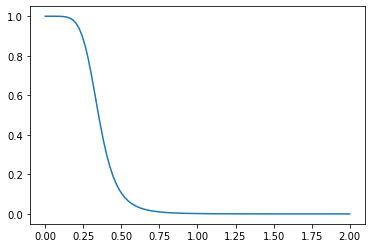

In [ ]:
# CONTACT FUNCTION DEFINITION

# (see formula for RATIONAL) https://www.plumed.org/doc-v2.6/user-doc/html/switchingfunction.html
def contact_function(x,r0=1.,d0=0,n=6,m=12):
    return ( 1-np.power(((x-d0)/r0),n) ) / ( 1-np.power(((x-d0)/r0),m) )

x = np.linspace(0,2,100)
plt.plot(x, contact_function(x,r0=0.35,d0=0,n=6,m=12))
# parameters explaination:
# d0 is when the function start acting
# r0 is where the contact is equal to 0.5
# n and m determine the steepness of the contact function 

In [ ]:
# H-BONDS DISTANCES / CONTACTS (donor-acceptor)

# find donors (OH or NH)
donors = [ at_i.index for at_i,at_j in traj.top.bonds  
            if ( ( at_i.element.symbol == 'O' ) | (at_i.element.symbol == 'N')  ) & ( at_j.element.symbol == 'H')]
# keep unique 
donors = sorted( list(set(donors)) )
print('Donors:',donors)

# find acceptors (O r N)
acceptors = traj.top.select('symbol O or symbol N')
print('Acceptors:',acceptors)

# lambda func to avoid selecting interaction within the same residue
atom_residue = lambda i : str(traj.top.atom(i)).split('-')[0] 
# compute pairs
pairs = [ (min(x,y),max(x,y)) for x in donors for y in acceptors if (x != y) and (atom_residue(x) != atom_residue(y) ) ]
# remove duplicates
pairs = sorted(list(set(pairs)))

# compute distances
dist = md.compute_distances(traj,pairs)
# labels
label = lambda i,j : 'HB_DIST %s%s -- %s%s' % (traj.top.atom(i), 's' if traj.top.atom(i).is_sidechain else '',
                                               traj.top.atom(j), 's' if traj.top.atom(j).is_sidechain else '')
#basename = 'hb_'
#names = [ basename+str(x)+'-'+str(y) for x,y in  pairs]
names = [ label(x,y) for x,y in pairs]

df = pd.DataFrame(data=dist,columns=names)
colvar = colvar.join(df)

# compute contacts
contacts = contact_function(dist,r0=0.35,d0=0,n=6,m=12)
# labels
#basename = 'hbc_'
#names = [ basename+str(x)+'-'+str(y) for x,y in pairs]
label = lambda i,j : 'HB_CONTACT %s%s -- %s%s' % (traj.top.atom(i), 's' if traj.top.atom(i).is_sidechain else '',
                                                  traj.top.atom(j), 's' if traj.top.atom(j).is_sidechain else '')
names = [ label(x,y) for x,y in pairs]

df2 = pd.DataFrame(data=contacts,columns=names)
colvar = colvar.join(df2)

df2 


Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]


,HB_CONTACT TYR1-N -- TYR2-N,HB_CONTACT TYR1-N -- TYR2-OHs,HB_CONTACT TYR1-N -- TYR2-O,HB_CONTACT TYR1-N -- ASP3-N,HB_CONTACT TYR1-N -- ASP3-OD1s,HB_CONTACT TYR1-N -- ASP3-OD2s,HB_CONTACT TYR1-N -- ASP3-O,HB_CONTACT TYR1-N -- PRO4-N,HB_CONTACT TYR1-N -- PRO4-O,HB_CONTACT TYR1-N -- GLU5-N,...,HB_CONTACT TRP9-N -- TYR10-O,HB_CONTACT TRP9-N -- TYR10-OXTs,HB_CONTACT TRP9-N -- TYR10-N,HB_CONTACT TRP9-N -- TYR10-OHs,HB_CONTACT TRP9-NE1s -- TYR10-O,HB_CONTACT TRP9-NE1s -- TYR10-OXTs,HB_CONTACT TRP9-NE1s -- TYR10-N,HB_CONTACT TRP9-NE1s -- TYR10-OHs,HB_CONTACT TRP9-O -- TYR10-N,HB_CONTACT TRP9-O -- TYR10-OHs
0,0.622849,0.001058,0.051079,0.023489,0.002046,0.001345,0.002735,0.002456,0.000449,0.000632,...,0.021409,0.024918,0.520840,0.039739,0.003809,0.003302,0.020370,0.001236,0.941509,0.043891
1,0.374462,0.000834,0.039752,0.026279,0.002058,0.002185,0.002959,0.002600,0.000397,0.000727,...,0.026178,0.021161,0.460170,0.019435,0.005536,0.004039,0.020811,0.000809,0.929196,0.031691
2,0.439010,0.001275,0.023889,0.015787,0.001536,0.001121,0.002361,0.001751,0.000345,0.000481,...,0.015959,0.038725,0.508344,0.011035,0.003348,0.013566,0.030998,0.000609,0.937323,0.015146
3,0.451558,0.000828,0.053424,0.031886,0.002288,0.002709,0.003507,0.002847,0.000416,0.000851,...,0.053685,0.018622,0.593333,0.019626,0.014907,0.003130,0.023063,0.000724,0.943660,0.013181
4,0.424292,0.000996,0.032970,0.031597,0.002634,0.002020,0.003224,0.002523,0.000468,0.000655,...,0.027733,0.032341,0.551518,0.016144,0.099313,0.330819,0.163395,0.001088,0.930683,0.015485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52470,0.413676,0.005633,0.021628,0.038071,0.002291,0.003359,0.025005,0.011739,0.002883,0.004367,...,0.038249,0.147790,0.844032,0.021229,0.003463,0.005635,0.052311,0.386497,0.938330,0.022104
52471,0.715906,0.012609,0.030061,0.221549,0.214110,0.028513,0.062499,0.013538,0.004812,0.002714,...,0.085878,0.035231,0.806402,0.008140,0.010496,0.012013,0.161606,0.418886,0.924692,0.008404
52472,0.505297,0.009764,0.022315,0.042041,0.007731,0.002674,0.036372,0.006764,0.002677,0.002441,...,0.092651,0.040787,0.766927,0.010035,0.008222,0.006869,0.099869,0.519901,0.933516,0.013321
52473,0.400732,0.017069,0.014953,0.067723,0.014466,0.007809,0.068846,0.009758,0.008175,0.014894,...,0.052960,0.087949,0.741522,0.005920,0.008643,0.011126,0.135981,0.396639,0.922199,0.007053


In [ ]:
# DIHEDRAL ANGLES
# phi,psi --> backbone
# chi1,chi2 --> sidechain

values_list = []
names_list = []

def get_dihedrals(traj,kind='phi',sincos=True):
    #retrieve topology
    table, _ = traj.top.to_dataframe()

    #prepare list for appending
    dihedrals = []
    names,values = [],[]
    
    if kind == 'phi':
        dihedrals = md.compute_phi(traj)
    elif kind == 'psi':
        dihedrals = md.compute_psi(traj)
    elif kind == 'chi1':
        dihedrals = md.compute_chi1(traj)
    elif kind == 'chi2':
        dihedrals = md.compute_chi2(traj)
    else:
        print( 'supported values: phi,psi,chi1,chi2' )

    idx_list = dihedrals[0]
    for i, idx in enumerate(idx_list):
        #find residue id from topology table
        #res = table['resSeq'][idx[0]]
        #name = 'dih_'+kind+'-'+str(res)
        res = table['resName'][idx[0]]+table['resSeq'][idx[0]].astype('str')
        name = 'BACKBONE '+ kind + ' ' + res
        if 'chi' in kind:
            name = 'SIDECHAIN '+ kind + ' ' + res
        names.append(name)
        values.append(dihedrals[1][:,i])
        if sincos:
            #names.append('cos_'+kind+'-'+str(res)) 
            name = 'BACKBONE '+ 'cos_'+ kind + ' ' + res
            if 'chi' in kind:
                name = 'SIDECHAIN '+ 'cos_'+ kind + ' ' + res
            names.append(name)
            values.append(np.cos( dihedrals[1][:,i] ))

            #names.append('sin_'+kind+'-'+str(res)) 
            name = 'BACKBONE '+ 'sin_'+ kind + ' ' + res
            if 'chi' in kind:
                name = 'SIDECHAIN '+ 'sin_'+ kind + ' ' + res
            names.append(name)
            values.append(np.sin( dihedrals[1][:,i] ))
    return names, values

for kind in ['phi','psi','chi1','chi2']:
    names, values = get_dihedrals(traj,kind,sincos=True)
    names_list.extend(names)
    values_list.extend(values)

df = pd.DataFrame(data=np.asarray(values_list).T,columns=names_list)
colvar = colvar.join(df)
df
#values_list

,BACKBONE phi TYR1,BACKBONE cos_phi TYR1,BACKBONE sin_phi TYR1,BACKBONE phi TYR2,BACKBONE cos_phi TYR2,BACKBONE sin_phi TYR2,BACKBONE phi ASP3,BACKBONE cos_phi ASP3,BACKBONE sin_phi ASP3,BACKBONE phi PRO4,...,SIDECHAIN sin_chi2 PRO4,SIDECHAIN chi2 GLU5,SIDECHAIN cos_chi2 GLU5,SIDECHAIN sin_chi2 GLU5,SIDECHAIN chi2 TRP9,SIDECHAIN cos_chi2 TRP9,SIDECHAIN sin_chi2 TRP9,SIDECHAIN chi2 TYR10,SIDECHAIN cos_chi2 TYR10,SIDECHAIN sin_chi2 TYR10
0,-2.802378,-0.943016,-0.332746,-1.961929,-0.381236,-0.924478,-1.129399,0.427204,-0.904155,-1.044915,...,-0.390129,-3.130611,-0.999940,-0.010981,1.669662,-0.098705,0.995117,1.579886,-0.009089,0.999959
1,-1.647477,-0.076605,-0.997061,-1.612325,-0.041517,-0.999138,-1.339162,0.229569,-0.973292,-1.404712,...,-0.521585,1.410696,0.159417,0.987211,1.978097,-0.396132,0.918193,1.935033,-0.356236,0.934396
2,-2.312177,-0.675307,-0.737537,-2.146757,-0.544640,-0.838670,-0.954109,0.578336,-0.815799,-1.239787,...,0.499438,2.866122,-0.962297,0.272000,-1.557036,0.013760,-0.999905,1.786988,-0.214512,0.976721
3,-1.280259,0.286467,-0.958090,-1.833037,-0.259246,-0.965811,-1.094865,0.458167,-0.888866,-1.420681,...,-0.618962,-3.060344,-0.996701,-0.081159,-1.894972,-0.318527,-0.947914,1.905820,-0.328791,0.944403
4,-1.916033,-0.338420,-0.940995,-1.413374,0.156773,-0.987635,-1.319649,0.248516,-0.968628,-1.191379,...,-0.287387,2.995318,-0.989321,0.145753,-1.116294,0.439016,-0.898479,1.567960,0.002836,0.999996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52470,-1.855256,-0.280639,-0.959813,-1.801870,-0.229023,-0.973421,-1.434898,0.135481,-0.990780,-1.464028,...,-0.726667,-2.817555,-0.947957,-0.318397,1.625115,-0.054292,0.998525,-0.802685,0.694778,-0.719224
52471,-1.545336,0.025458,-0.999676,-1.676052,-0.105062,-0.994466,-1.191619,0.370156,-0.928970,-1.188391,...,-0.478439,-2.803253,-0.943307,-0.331921,1.700710,-0.129549,0.991573,-1.010977,0.531033,-0.847351
52472,-1.493065,0.077653,-0.996980,-0.979568,0.557382,-0.830256,-1.172225,0.388103,-0.921616,-1.114608,...,-0.624779,2.842788,-0.955689,0.294378,1.490473,0.080237,0.996776,-0.654335,0.793453,-0.608632
52473,-1.614367,-0.043557,-0.999051,-1.999589,-0.415773,-0.909468,-1.033706,0.511638,-0.859201,-1.650120,...,0.531599,3.085804,-0.998444,0.055760,1.629964,-0.059133,0.998250,-0.893910,0.626369,-0.779527


### Compute properties (optional)

In [ ]:
# RMSD analysis w.r.t. experimental NMR structure, using only CA atoms
#rmsd = md.rmsd(traj,ref,atom_indices=ref.top.select('name CA'))

# all heavy atoms RMSD
rmsd = md.rmsd(traj,ref,atom_indices=ref.top.select('not type H'))

#running average
N=5
run_rmsd = np.convolve(rmsd, np.ones(N)/N, mode='same')

kmeans = KMeans(n_clusters=2).fit(run_rmsd.reshape(-1, 1))

#plt.figure(dpi=300)
#plt.scatter(colvar['time'],run_rmsd,c=kmeans.labels_.astype('float32'),s=1)


### Perform H-bonds analysis

In [ ]:
# Hydrogen bonds

from collections import Counter

# label function
hb_label = lambda hbond : '%s%s -- %s%s' % (traj.top.atom(hbond[0]), 's' if traj.top.atom(hbond[0]).is_sidechain else '', 
                                         traj.top.atom(hbond[1]), 's' if traj.top.atom(hbond[1]).is_sidechain else '')

def compute_hbonds_frequency(traj):
    # compute hbonds
    hbonds = md.wernet_nilsson(traj)
    hbonds_list = [ hb.tolist() for hb in hbonds ]
    #remove info about H atom
    hbonds_list = [ [item[0],item[2]] for sublist in hbonds_list for item in sublist]

    #compute frequency
    count = Counter(map(tuple, hbonds_list))
    count = dict(sorted(count.items(), key=lambda item: item[1],reverse=True))

    return count

print('Syntax for atoms: [RESIDUE NAME][RESIDUE NUMBER]-[ATOM NAME][s if belongs to sidechain]\n')

for i in range(n_clusters):
    print ('============== STATE %d ==============' % (i))
    print ( '[ Tica1: %f  &  Tica2: %f]' % (kmeans.cluster_centers_[i][0],kmeans.cluster_centers_[i][1]) )
    # select configurations
    traj_i = traj[ (colvar['basin'] == i ).values ]
    count = compute_hbonds_frequency(traj_i)

    print('Donor  --  Acceptor \t Frequency')
    for key,value in count.items():
        freq = value/len(traj_i)*100
        if freq > 20:
            print(hb_label(key),'\t',np.round(freq,1),'%')
    print('')

Syntax for atoms: [RESIDUE NAME][RESIDUE NUMBER]-[ATOM NAME][s if belongs to sidechain]

============== STATE 0 ==============


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
colvar.to_csv('data/chignolin-v3/chignolin_unbiased_colvar.csv')

### Select configurations for classifier

In [ ]:
regex_selection = 'CA|HB_DIST|cos_|sin_'
config_per_basin = 5000

config_list = []
features_names = []
labels = []

for i in range(n_clusters):
    #select basin
    colvar_i = colvar.loc[ (colvar['basin'] == i) & (colvar['selection'] == 1) ]
    #select descriptors and sample
    config_i = colvar_i.filter(regex=regex_selection).sample(n=config_per_basin).values
    config_list.append(config_i)
    labels.extend([i]*config_per_basin)
    print(i,config_i.shape)
    features_names = colvar_i.filter(regex=regex_selection).columns.values

labels = np.array(labels, dtype=np.int_)
configurations = np.vstack(config_list)

colvar_i.filter(regex=regex_selection)
features_names

0 (5000, 431)
1 (5000, 431)
2 (5000, 431)
3 (5000, 431)


array(['DIST. TYR1-CA -- TYR2-CA', 'DIST. TYR1-CA -- ASP3-CA',
       'DIST. TYR1-CA -- PRO4-CA', 'DIST. TYR1-CA -- GLU5-CA',
       'DIST. TYR1-CA -- THR6-CA', 'DIST. TYR1-CA -- GLY7-CA',
       'DIST. TYR1-CA -- THR8-CA', 'DIST. TYR1-CA -- TRP9-CA',
       'DIST. TYR1-CA -- TYR10-CA', 'DIST. TYR2-CA -- ASP3-CA',
       'DIST. TYR2-CA -- PRO4-CA', 'DIST. TYR2-CA -- GLU5-CA',
       'DIST. TYR2-CA -- THR6-CA', 'DIST. TYR2-CA -- GLY7-CA',
       'DIST. TYR2-CA -- THR8-CA', 'DIST. TYR2-CA -- TRP9-CA',
       'DIST. TYR2-CA -- TYR10-CA', 'DIST. ASP3-CA -- PRO4-CA',
       'DIST. ASP3-CA -- GLU5-CA', 'DIST. ASP3-CA -- THR6-CA',
       'DIST. ASP3-CA -- GLY7-CA', 'DIST. ASP3-CA -- THR8-CA',
       'DIST. ASP3-CA -- TRP9-CA', 'DIST. ASP3-CA -- TYR10-CA',
       'DIST. PRO4-CA -- GLU5-CA', 'DIST. PRO4-CA -- THR6-CA',
       'DIST. PRO4-CA -- GLY7-CA', 'DIST. PRO4-CA -- THR8-CA',
       'DIST. PRO4-CA -- TRP9-CA', 'DIST. PRO4-CA -- TYR10-CA',
       'DIST. GLU5-CA -- THR6-CA', 'DIST. GLU5-CA -

### To-do list

* Trajectories
    * Chignolin from unbiased simulation
    * Chignolin from enhanced sampling
    * BPTI (Narjes)

* Descriptors set
    * Dihedral angles (sin\_,cos\_)
    * HB distances (hb\_)
    * HB contacts (hbc\_)
    * Dihedral + CA distances (sin\_,cos\_,ca\_)
    * Dihedral + HB distances (sin\_,cos\_,hb\_)
    * Dihedral + HB  contacts (sin\_,cos\_,hbc\_)
    * Dihedral + CA distances + HB distances (sin\_,cos\_,ca\_,hb\_)

### Questions

* The solutions are stable w.r.t. the set of features?
* Check symmetry issues (most importantly on different sets of trajectories)
    * Possibly devise an algorithm to spot easy symmetries like $\pi$ flips
* Polynomial kernel to obtain ''correlated'' features
* Group lasso on the macro groups of features

### Interesting points
* The clusters are linearly separable in a _nonlinear_ embedding of the features. If LASSO works with 100\% accuracy, then the clusters are linearly separable in the features space.


### Label features by indexes

State 1 features
hb 0-145
hb 0-146
hb 22-147
hb 36-69
State 2 features
hb 91-105
hb 91-112
State 3 features
hb 91-98
hb 106-112
State 4 features

In [ ]:
#return atom names given indexes
label = lambda i,j : '%s%s -- %s%s' % (traj.top.atom(i), 's' if traj.top.atom(i).is_sidechain else '',
                                      traj.top.atom(j), 's' if traj.top.atom(j).is_sidechain else '')

features = [ ['hb_0-145', 'hb_0-146', 'hb_22-147', 'hb_36-69'], ['hb_91-105','hb_91-112'],['hb_91-98','hb_106-112'], [] ]

for k,feat in enumerate(features):
    print('State %d features' % (k+1))
    for ff in feat:
        i,j = ff.split('_')[-1].split('-')
        i,j = int(i),int(j)
        print(i,j,label(i,j))

State 1 features
0 145 TYR1-N -- TYR10-O
0 146 TYR1-N -- TYR10-OXTs
22 147 TYR1-O -- TYR10-N
36 69 TYR2-OHs -- PRO4-O
State 2 features
91 105 THR6-OG1s -- GLY7-O
91 112 THR6-OG1s -- THR8-OG1s
State 3 features
91 98 THR6-OG1s -- THR6-O
106 112 THR8-N -- THR8-OG1s
State 4 features


Lasso on Hbonds analysis

No handles with labels found to put in legend.
No handles with labels found to put in legend.
State 1 features
0 145 TYR1-N -- TYR10-O
(52475, 1)
0 146 TYR1-N -- TYR10-OXTs
(52475, 1)
22 147 TYR1-O -- TYR10-N
(52475, 1)
36 69 TYR2-OHs -- PRO4-O
(52475, 1)
State 2 features
91 105 THR6-OG1s -- GLY7-O
(52475, 1)
91 112 THR6-OG1s -- THR8-OG1s
(52475, 1)
State 3 features
91 98 THR6-OG1s -- THR6-O
No handles with labels found to put in legend.
No handles with labels found to put in legend.
(52475, 1)
106 112 THR8-N -- THR8-OG1s
(52475, 1)
State 4 features


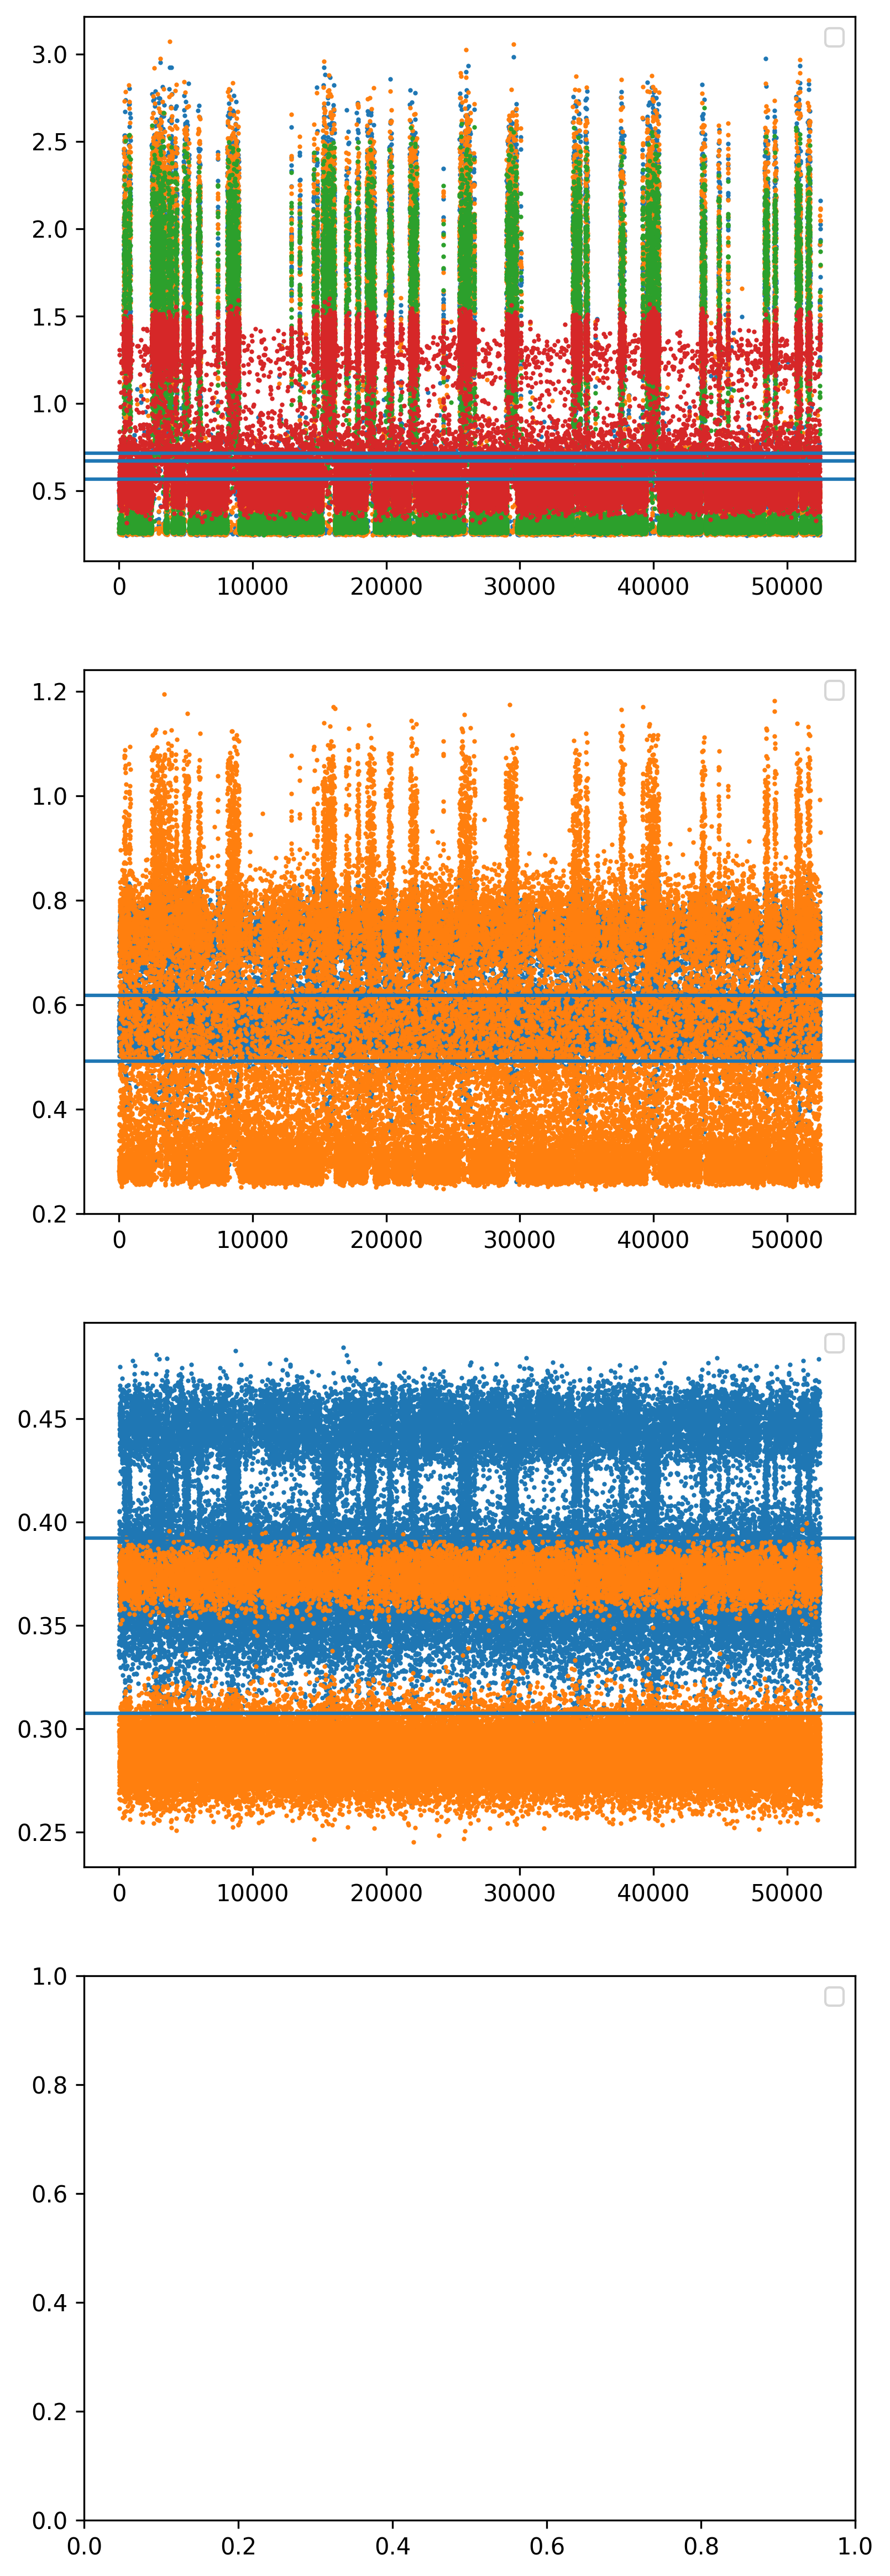

In [ ]:
features = [ ['hb_0-145', 'hb_0-146', 'hb_22-147', 'hb_36-69'], ['hb_91-105','hb_91-112'],['hb_91-98','hb_106-112'], [] ]

fig,axs = plt.subplots(len(features),1,figsize=(6,20),dpi=300)
for k,feat in enumerate(features):
    print('State %d features' % (k+1))
    ax = axs[k]
    for ff in feat:
        i,j = ff.split('_')[-1].split('-')
        i,j = int(i),int(j)
        print(i,j,label(i,j))
        dij = md.compute_distances(traj,np.asarray([[i,j]]))
        print(dij.shape)
        ax.scatter(np.arange(len(dij)),dij,s=1,label='')
        ax.axhline(np.mean(dij))
    ax.legend()

### Lasso classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import concurrent.futures
from scipy.sparse import csr_matrix

scaler = StandardScaler(with_mean=True)
scaler.fit(configurations)
scaled_configurations = scaler.transform(configurations)

#Train test splitting
train_val_dataset = train_test_split(scaled_configurations, labels)

In [ ]:

#Lasso Path
def CV_path(dataset, C_range, l1_ratio=None, **kwargs):
    coeffs = []
    train_in, val_in, train_out, val_out = dataset
    _is_lasso = kwargs.get('LASSO', False)
    try:
        del kwargs['LASSO']
    except:
        pass

    if _is_lasso:
        def _train_model(C):
            model = LogisticRegression(penalty='l1', C=C, solver='saga', multi_class="multinomial", fit_intercept=False, **kwargs) 
            #Model Fit
            model.fit(train_in,train_out)
            score = model.score(val_in,val_out)
            return (C, model.coef_,score)
    else:
        def _train_model(C):
            model = LogisticRegression(penalty='elasticnet', C=C, solver='saga', l1_ratio=l1_ratio, multi_class="multinomial", fit_intercept=False, **kwargs) 
            #Model Fit
            model.fit(train_in,train_out)
            score = model.score(val_in,val_out)
            return (C, model.coef_,score)
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        fut = [executor.submit(_train_model, C) for C in C_range]
        for fut_result in concurrent.futures.as_completed(fut):
            coeffs.append(fut_result.result())

    C_arr = []
    coeff_arr = []
    CV_arr = []
    for data in coeffs:
        C_arr.append(data[0])
        coeff_arr.append(data[1])
        CV_arr.append(data[2])

    C_arr = np.array(C_arr)
    coeff_arr = np.array(coeff_arr)
    CV_arr = np.array(CV_arr)
    sort_perm = np.argsort(C_arr)

    return C_arr[sort_perm], np.squeeze(coeff_arr[sort_perm]), CV_arr[sort_perm]

In [ ]:
C_range = np.geomspace(2, 100, 25)
kwargs = {'LASSO':True, 'max_iter':1000}
n_examples = train_val_dataset[0].shape[0]
_, coeffs_LASSO, CV_LASSO = CV_path(train_val_dataset, C_range/n_examples, **kwargs)

Text(0.5, 1.0, 'Score')

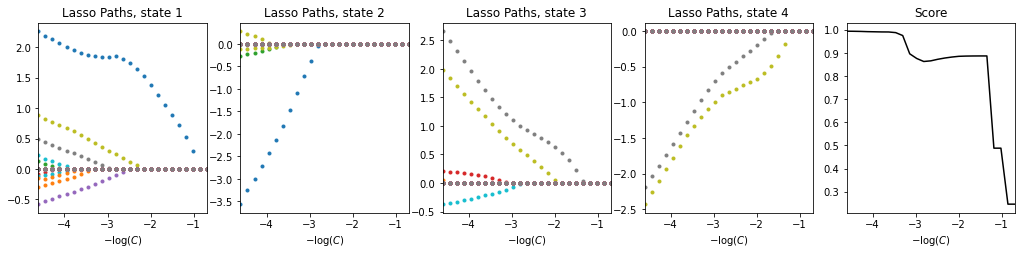

In [ ]:
descs = [f'Lasso Paths, state {idx +1}' for idx in range(coeffs_LASSO.shape[1])]
#colors = ['k', 'r--', 'g-']
fig, axes = plt.subplots(ncols = coeffs_LASSO.shape[1] + 1, figsize=(17.5,3.5))
for idx in range(coeffs_LASSO.shape[1]):
    ax = axes[idx]
    ax.plot(np.log(1/C_range), coeffs_LASSO[:,idx,:], '.')
    ax.set_xlim(np.log(1/C_range[-1]), np.log(1/C_range[0]))
    ax.set_xlabel(r"$-\log(C)$")
    ax.set_title(descs[idx])
ax = axes[-1]
ax.plot(np.log(1/C_range), CV_LASSO, 'k-')
ax.set_xlim(np.log(1/C_range[-1]), np.log(1/C_range[0]))
ax.set_xlabel(r"$-\log(C)$")
ax.set_title("Score")

In [ ]:
def get_features(C, coeffs_LASSO, C_range, features_names):
    #Find idx of C_range closer to C
    C_idx = np.argmin(np.abs(C_range - C))
    selected_coefficients = coeffs_LASSO[C_idx]
    relevant_features = []
    for state_idx, coef in enumerate(selected_coefficients):
        sparse_coef = csr_matrix(coef)
        model_idxs = sparse_coef.indices
        print(f"Features relevant to recognize state {state_idx}:")
        state_feats = []
        for feat_idx in model_idxs:
            feature = features_names[feat_idx]
            print(f'\t{feature}')
            state_feats.append((feature, feat_idx))
        relevant_features.append(state_feats)
    return relevant_features

In [ ]:
features = get_features(np.exp(2), coeffs_LASSO, C_range, features_names)
features

Features relevant to recognize state 0:
	cos_chi1-3
Features relevant to recognize state 1:
Features relevant to recognize state 2:
	sin_chi1-6
	cos_chi1-8
Features relevant to recognize state 3:
	sin_chi1-6
	cos_chi1-8


[[('cos_chi1-3', 40)],
 [],
 [('sin_chi1-6', 47), ('cos_chi1-8', 48)],
 [('sin_chi1-6', 47), ('cos_chi1-8', 48)]]

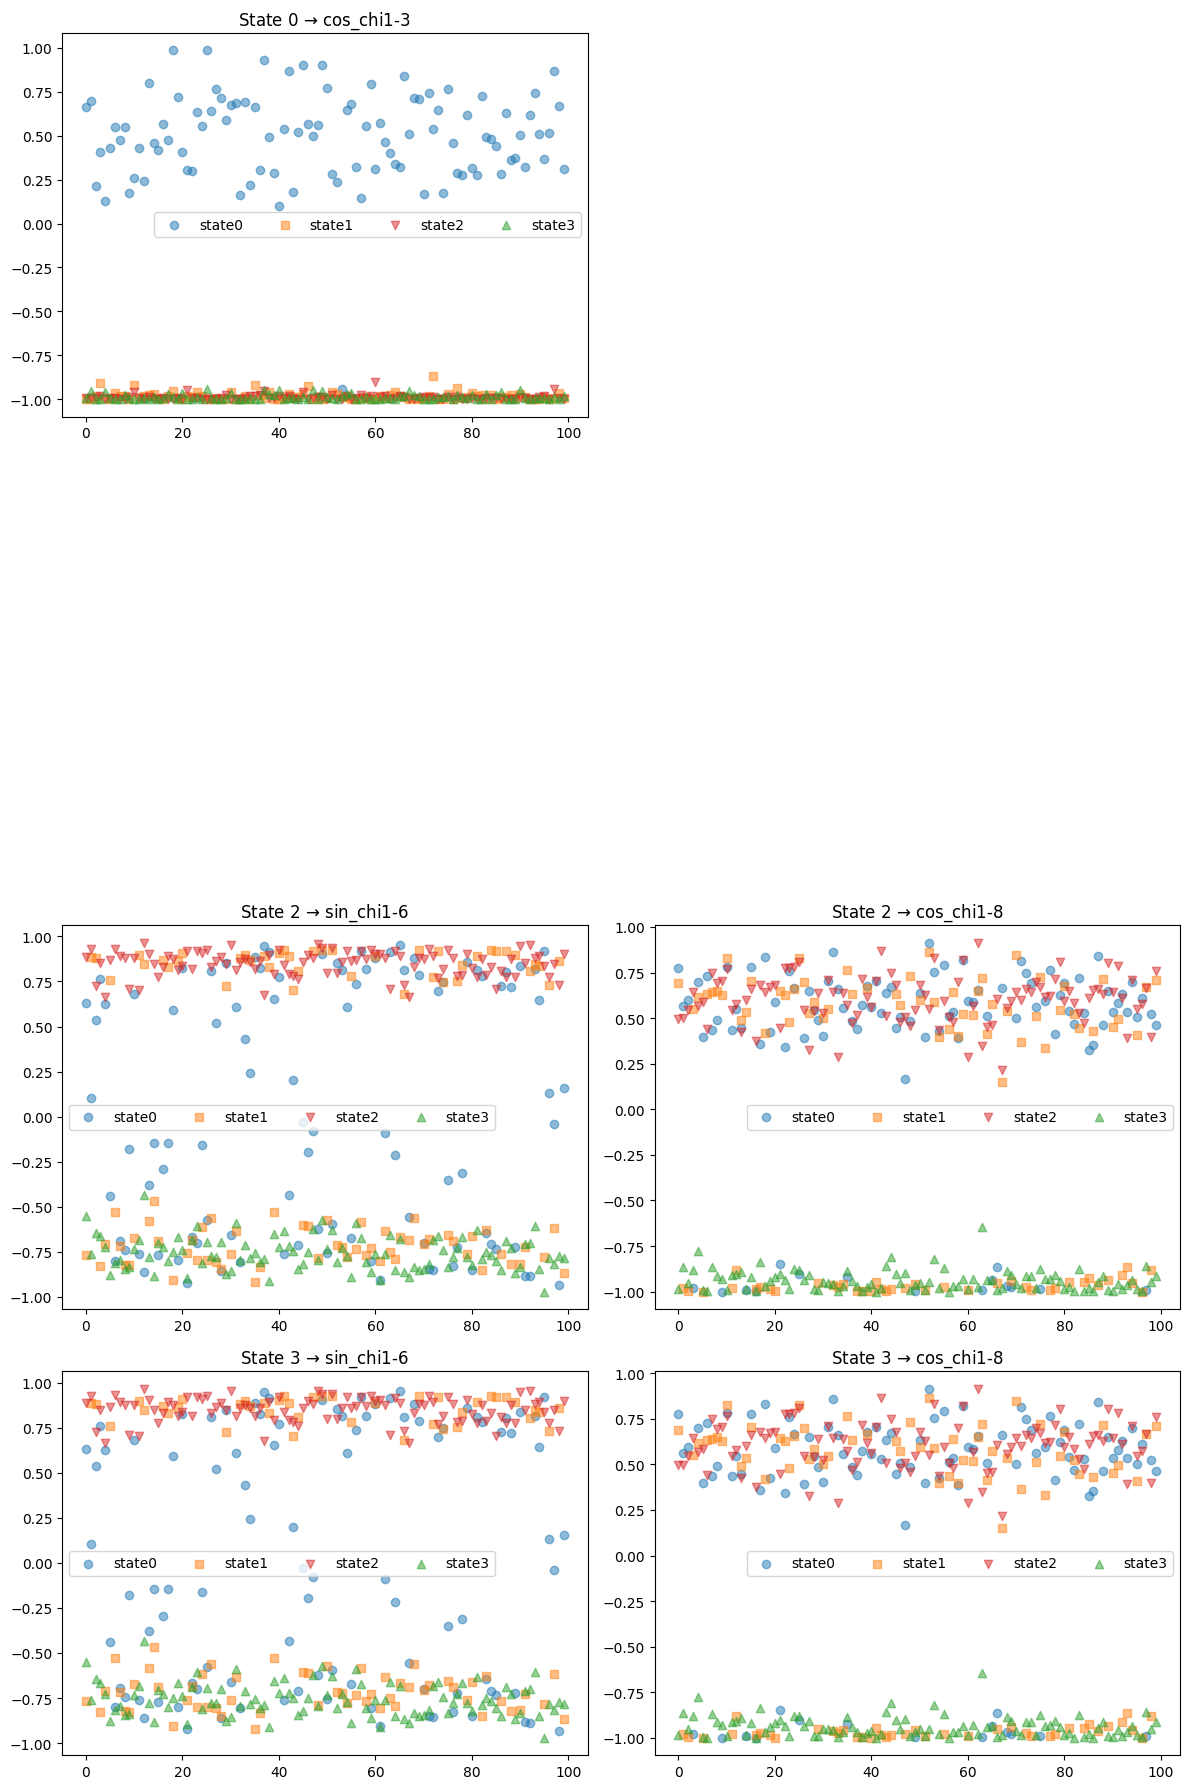

In [ ]:
#features = [['dd_32-119', 'dd_32-125'],['chi1-6', 'chi1-8'],['chi1-6', 'chi1-8'],['chi1-6', 'chi1-8']]

nrows=4
ncols=2

fig,axs=plt.subplots(nrows,ncols,figsize=(12,18),dpi=100)

colors=['tab:blue','tab:orange','tab:red','tab:green']
markers=['o','s','v','^']

for i in range(4):
    for j,feature_tuple in enumerate(features[i]):
        feature, feat_idx = feature_tuple
        ax = axs[i,j]
        ax.set_title(r'State '+str(i)+r' $\to$ '+feature)
        for k,config in enumerate(config_list):
            ax.scatter(np.arange(config.shape[0])[:100],config[:100,feat_idx],label='state'+str(k),alpha=0.5,color=colors[k],marker=markers[k])
        ax.legend(ncol=4)
        
    for j in range(len(features[i]),ncols):
        axs[i,j].axis('off')
plt.tight_layout()

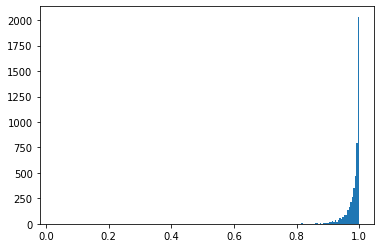

In [ ]:

plt.hist(np.abs(config_list[1][:,40]), bins=200);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fa81218d-8afb-4a4f-8164-247b0de78a96' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>